In [47]:
import torch.nn.functional as F
import torch
import torchvision
from matplotlib import pyplot as plt
from torchvision import utils
import numpy as np
import torch.nn as nn
import os
import pandas as pd
import PIL
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/Solo testo")

myseed = 0
torch.manual_seed(myseed)
np.random.seed(myseed)
generator=torch.Generator()
generator.manual_seed(myseed)

%matplotlib inline

In [48]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cpu


In [49]:
data_path = "./"

In [50]:
images = os.listdir(f"{data_path}DATASET")
print(images)

['P_3_64.png', 'P_3_60.png', 'P_501.png', 'P_3_424.png', 'P_1_128.png', 'P_471.png', 'P_716.png', 'P_669.png', 'P_217.png', 'P_486.png', 'P_1_163.png', 'P_3_106.png', 'P_3_36.png', 'P_8.png', 'P_59.png', 'P_3_382.png', 'P_1_38.png', 'P_3_468.png', 'P_3_154.png', 'P_628.png', 'P_663.png', 'P_327.png', 'P_3_169.png', 'P_790.png', 'P_3_374.png', 'P_143.png', 'P_3_102.png', 'P_733.png', 'P_3_118.png', 'P_19.png', 'P_3_407.png', 'P_1_59.png', 'P_1_12.png', 'P_113.png', 'P_341.png', 'P_1_148.png', 'P_1_80.png', 'P_424.png', 'P_3_311.png', 'P_1_49.png', 'P_3_98.png', 'P_602.png', 'P_181.png', 'P_3_358.png', 'P_191.png', 'P_1_84.png', 'P_659.png', 'P_620.png', 'P_571.png', 'P_3_125.png', 'P_2_65.png', 'P_810.png', 'P_3_415.png', 'P_667.png', 'P_1_99.png', 'P_584.png', 'P_608.png', 'P_718.png', 'P_2_14.png', 'P_664.png', 'P_442.png', 'P_3_325.png', 'P_817.png', 'P_1_106.png', 'P_252.png', 'P_2_94.png', 'P_3_72.png', 'P_3_166.png', 'P_110.png', 'P_3_145.png', 'P_37.png', 'P_137.png', 'P_547.png'

In [51]:
len(images)

1589

In [52]:
df = pd.read_excel("trainANDtest.xls")

In [53]:
del df["Row_number"]
del df["Unnamed: 0"]

In [54]:
df

,ImageFile,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,...,pH,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Prognosis,Death
0,P_102.png,1,72,1,1,37.3,3,1,0,5.37,...,7.46,0,0,0,0,1,0,0,1,0
1,P_131.png,4,35,0,1,39.3,3,1,0,5.76,...,7.46,1,0,0,0,0,0,0,0,0
2,P_132.png,4,57,0,1,37.0,3,0,0,11.48,...,7.42,0,0,0,0,0,0,0,0,0
3,P_117.png,1,39,1,1,37.2,2,1,0,10.17,...,7.38,0,0,0,0,0,0,0,0,0
4,P_16.png,1,44,0,1,38.0,3,1,0,6.64,...,7.47,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,P_3_432.png,6,84,1,1,37.0,2,0,0,7.20,...,7.46,1,0,1,0,0,0,0,0,0
1585,P_3_105.png,6,51,0,1,38.0,3,0,1,6.40,...,7.44,0,1,0,0,0,0,0,1,0
1586,P_3_233.png,6,70,1,1,36.4,2,1,0,6.00,...,7.50,1,0,0,0,0,0,0,0,0
1587,P_3_414.png,6,90,0,1,36.2,4,0,0,7.10,...,7.42,0,1,0,0,0,0,0,0,0


In [55]:
class TextDataset(Dataset):
    """Tabular and Image dataset."""

    def __init__(self, indices, image_dir, transform=None):
        self.image_dir = image_dir
        self.indices = indices
        #self.tabular = self.tabular[self.tabular["Hospital"]=="A"]
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tabular = self.indices.iloc[idx, 0:]

        y = tabular["Prognosis"]

        #image = PIL.Image.open(f"{self.image_dir}/{tabular['ImageFile']}")
        #image = image.convert('L')
        #image = np.array(image)
        #image = image[..., :3]

        #image = transforms.functional.to_tensor(image)

        tabular = tabular[['Age', 'Sex', 'PositivityAtAdmission',
       'Temp_C', 'DaysFever', 'Cough', 'DifficultyInBreathing', 'WBC', 'RBC',
       'CRP', 'Glucose', 'LDH', 'INR', 'PaO2', 'PaCO2', 'pH',
       'HighBloodPressure', 'Diabetes', 'Dementia', 'BPCO', 'Cancer',
       'ChronicKidneyDisease', 'RespiratoryFailure']]
        tabular = tabular.tolist()
        tabular = torch.FloatTensor(tabular)
        
        #if self.transform:
            #image = self.transform(image)

        return tabular, y
    
from torchvision import transforms as T
my_transform = T.Compose([T.Resize((256,256)),
                          T.RandomApply(
                            [T.RandomHorizontalFlip(),
                             T.RandomCrop(256, padding=4)],
                            p=.5
                          )])

In [56]:
from sklearn.model_selection import train_test_split

tv_idx, test_idx = train_test_split(np.arange(len(df["Prognosis"])), test_size=0.2, shuffle=True, stratify=df["Prognosis"])


In [57]:
train_val_df = df.iloc[tv_idx]
train_val = TextDataset(indices=train_val_df, image_dir=f"{data_path}DATASET", transform=my_transform)

In [58]:
len(train_val)

1271

In [59]:
test_df = df.iloc[test_idx]
test_set = TextDataset(indices=test_df, image_dir=f"{data_path}DATASET", transform=my_transform)

In [60]:
len(test_set)

318

In [61]:
i = 3
print(f"{train_val[i][0].size()}, label = {train_val[i][1]}")

torch.Size([23]), label = 0


In [62]:
# dev = torch.device('cuda')
# print(dev)
dev = torch.device("cpu")
print(dev)

cpu


# 2. SOLO TESTO

In [63]:
class TextNN(nn.Module):

    #Constructor
    def __init__(self):
    # Call parent contructor
        super().__init__()
        torch.manual_seed(myseed)
        self.relu = nn.ReLU()
        self.ln1 = nn.Linear(23, 50) #23 sono le colonne in input
        self.ln2 = nn.Linear(50, 50)
        self.ln3 = nn.Linear(50, 10)
        self.ln4 = nn.Linear(10, 1)
    
    def forward(self, tab):
        tab = self.ln1(tab)
        tab = self.relu(tab)
        tab = self.ln2(tab)
        tab = self.relu(tab)
        tab = self.ln3(tab)
        tab = self.relu(tab)
        tab = self.ln4(tab)

        return tab

model = TextNN()
print(model)

TextNN(
  (relu): ReLU()
  (ln1): Linear(in_features=23, out_features=50, bias=True)
  (ln2): Linear(in_features=50, out_features=50, bias=True)
  (ln3): Linear(in_features=50, out_features=10, bias=True)
  (ln4): Linear(in_features=10, out_features=1, bias=True)
)


In [64]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
# Define a loss 
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs=5, steps_per_epoch=350)

In [65]:
def train(net, loaders, optimizer, criterion, epochs=500, dev=dev, save_param=False, model_name="only-text"):
    torch.manual_seed(myseed)
    # Initialize history
    history_loss = {"train": [], "val": [], "test": []}
    history_accuracy = {"train": [], "val": [], "test": []}
    best_val_accuracy = 0  # Store the best val accuracy
    
    try:
        net = net.to(dev)
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                    net.train()
                else:
                    net.eval()
                # Process each batch
                for (tabular, labels) in loaders[split]:
                    # Move to CUDA
                    tabular = tabular.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(tabular)
                    labels = labels.unsqueeze(1).float()
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    if split == "train":
                        loss.backward()
                        optimizer.step()
                    # Compute accuracy
                    pred_labels = (pred >= 0).long()  # Binarize predictions
                    batch_accuracy = (pred_labels == labels).sum().item() / tabular.size(0)
                    sum_accuracy[split] += batch_accuracy
                scheduler.step()
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split] / len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split] / len(loaders[split]) for split in ["train", "val", "test"]}

            if save_param and epoch_accuracy["val"] > best_val_accuracy:
                torch.save(net.state_dict(), f"{model_name}_best_val.pth")
                best_val_accuracy = epoch_accuracy["val"]

            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])

            writer.add_scalar("Train Loss", epoch_loss['train'], epoch)
            writer.add_scalar("Valid Loss", epoch_loss['val'], epoch)
            writer.add_scalar("Test Loss", epoch_loss['test'], epoch)
            writer.add_scalar("Train Accuracy", epoch_accuracy['train'], epoch)
            writer.add_scalar("Valid Accuracy", epoch_accuracy['val'], epoch)
            writer.add_scalar("Test Accuracy", epoch_accuracy['test'], epoch)

            # Print info
            print(f"Epoch {epoch + 1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},",
                  f"LR={optimizer.param_groups[0]['lr']:.5f},")
    except KeyboardInterrupt:
        print("Interrupted")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()


In [66]:
def reset_weights(m):

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [67]:
test_loader  = DataLoader(test_set,  batch_size=8, num_workers=2, drop_last=False, shuffle=False, generator=generator)

In [68]:
tv_labels = train_val_df['Prognosis'].tolist()

------------fold no---------0----------------------
Total samples in hospital A: 99
Total samples in hospital B: 76
Total samples in hospital C: 120
Total samples in hospital D: 115
Total samples in hospital E: 66
Total samples in hospital F: 540


Epoch 1: TrL=0.6634, TrA=0.6447, VL=0.5608, VA=0.7104, TeL=0.6004, TeA=0.7135, LR=0.00040,
Epoch 2: TrL=0.6109, TrA=0.6831, VL=0.5590, VA=0.7143, TeL=0.5854, TeA=0.7167, LR=0.00040,
Epoch 3: TrL=0.5847, TrA=0.7106, VL=0.5488, VA=0.7143, TeL=0.5732, TeA=0.7167, LR=0.00041,
Epoch 4: TrL=0.5777, TrA=0.7156, VL=0.5506, VA=0.7299, TeL=0.5664, TeA=0.7260, LR=0.00041,
Epoch 5: TrL=0.5696, TrA=0.7185, VL=0.5456, VA=0.7227, TeL=0.5689, TeA=0.7229, LR=0.00042,
Epoch 6: TrL=0.5667, TrA=0.7215, VL=0.5451, VA=0.7104, TeL=0.5614, TeA=0.7292, LR=0.00043,
Epoch 7: TrL=0.5555, TrA=0.7254, VL=0.5605, VA=0.6942, TeL=0.5597, TeA=0.7000, LR=0.00044,
Epoch 8: TrL=0.5543, TrA=0.7303, VL=0.5384, VA=0.7070, TeL=0.5575, TeA=0.7198, LR=0.00045,
Epoch 9: TrL=0.5508, TrA=0.7313, VL=0.5575, VA=0.7266, TeL=0.5743, TeA=0.7104, LR=0.00046,
Epoch 10: TrL=0.5512, TrA=0.7382, VL=0.5505, VA=0.7148, TeL=0.5648, TeA=0.7135, LR=0.00048,
Epoch 11: TrL=0.5462, TrA=0.7313, VL=0.5496, VA=0.6908, TeL=0.5384, TeA=0.7354, LR=0.0004

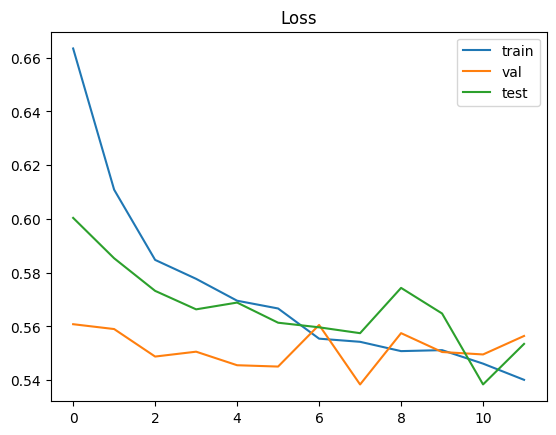

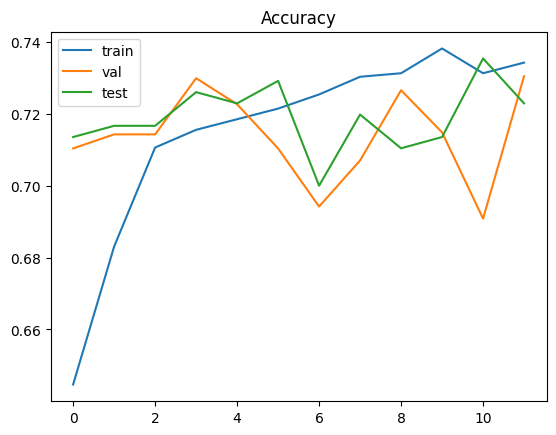

------------fold no---------1----------------------
Total samples in hospital A: 85
Total samples in hospital B: 81
Total samples in hospital C: 124
Total samples in hospital D: 95
Total samples in hospital E: 86
Total samples in hospital F: 546
Epoch 1: TrL=0.6485, TrA=0.6388, VL=0.6047, VA=0.6953, TeL=0.6010, TeA=0.7104, LR=0.00040,
Epoch 2: TrL=0.5859, TrA=0.6929, VL=0.5805, VA=0.7031, TeL=0.5748, TeA=0.7104, LR=0.00040,
Epoch 3: TrL=0.5750, TrA=0.6978, VL=0.5766, VA=0.7135, TeL=0.5668, TeA=0.7260, LR=0.00041,
Epoch 4: TrL=0.5599, TrA=0.7185, VL=0.5688, VA=0.7135, TeL=0.5615, TeA=0.7229, LR=0.00041,
Epoch 5: TrL=0.5593, TrA=0.7244, VL=0.5632, VA=0.7227, TeL=0.5549, TeA=0.7323, LR=0.00042,
Epoch 6: TrL=0.5470, TrA=0.7461, VL=0.5814, VA=0.7083, TeL=0.5886, TeA=0.6979, LR=0.00043,
Epoch 7: TrL=0.5477, TrA=0.7293, VL=0.5667, VA=0.7292, TeL=0.5603, TeA=0.7104, LR=0.00044,
Epoch 8: TrL=0.5483, TrA=0.7293, VL=0.5515, VA=0.7409, TeL=0.5519, TeA=0.7260, LR=0.00045,
Epoch 9: TrL=0.5420, TrA=0

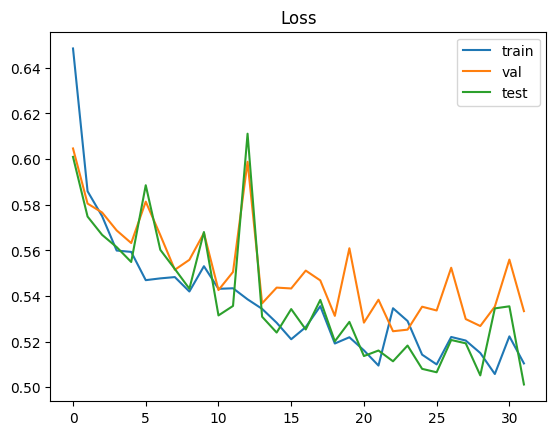

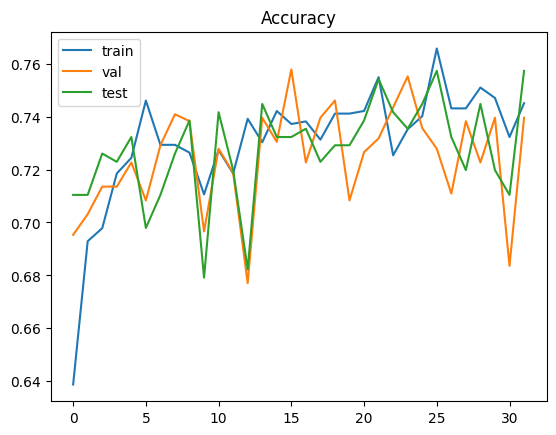

------------fold no---------2----------------------
Total samples in hospital A: 84
Total samples in hospital B: 79
Total samples in hospital C: 127
Total samples in hospital D: 99
Total samples in hospital E: 81
Total samples in hospital F: 547
Epoch 1: TrL=0.6466, TrA=0.6358, VL=0.6643, VA=0.6706, TeL=0.6260, TeA=0.6854, LR=0.00040,
Epoch 2: TrL=0.5822, TrA=0.7028, VL=0.6798, VA=0.6745, TeL=0.6290, TeA=0.6885, LR=0.00040,
Epoch 3: TrL=0.5769, TrA=0.6870, VL=0.6327, VA=0.6992, TeL=0.5893, TeA=0.7104, LR=0.00041,
Epoch 4: TrL=0.5720, TrA=0.7067, VL=0.6156, VA=0.7422, TeL=0.5760, TeA=0.7198, LR=0.00041,
Epoch 5: TrL=0.5776, TrA=0.6949, VL=0.6017, VA=0.7070, TeL=0.5727, TeA=0.7135, LR=0.00042,
Epoch 6: TrL=0.5691, TrA=0.6978, VL=0.5979, VA=0.7148, TeL=0.5695, TeA=0.7104, LR=0.00043,
Epoch 7: TrL=0.5641, TrA=0.7136, VL=0.5823, VA=0.7070, TeL=0.5609, TeA=0.7135, LR=0.00044,
Epoch 8: TrL=0.5572, TrA=0.7087, VL=0.5935, VA=0.7292, TeL=0.5661, TeA=0.7292, LR=0.00045,
Epoch 9: TrL=0.5541, TrA=0

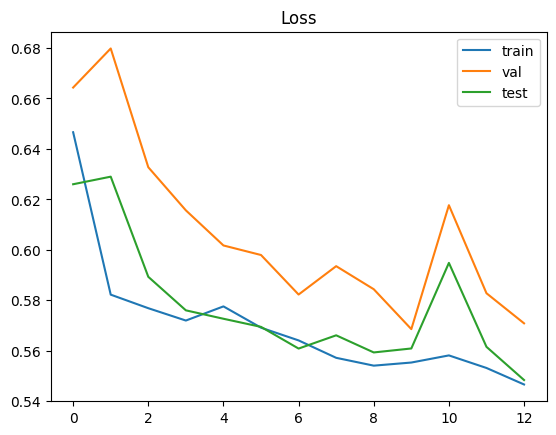

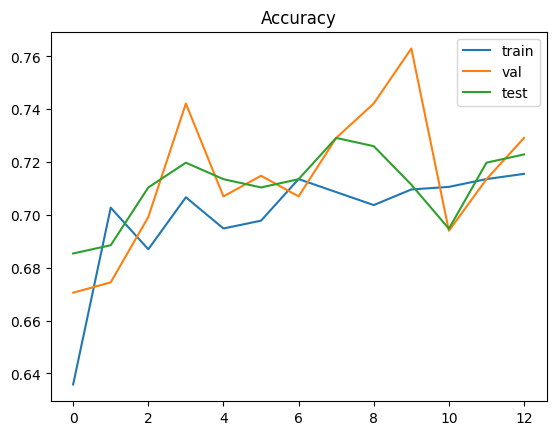

------------fold no---------3----------------------
Total samples in hospital A: 98
Total samples in hospital B: 77
Total samples in hospital C: 100
Total samples in hospital D: 108
Total samples in hospital E: 70
Total samples in hospital F: 564
Epoch 1: TrL=0.6616, TrA=0.6240, VL=0.6111, VA=0.6602, TeL=0.6041, TeA=0.6823, LR=0.00040,
Epoch 2: TrL=0.5930, TrA=0.6870, VL=0.5631, VA=0.7161, TeL=0.5971, TeA=0.6917, LR=0.00040,
Epoch 3: TrL=0.5899, TrA=0.6890, VL=0.5574, VA=0.7201, TeL=0.5898, TeA=0.6979, LR=0.00041,
Epoch 4: TrL=0.5709, TrA=0.7067, VL=0.5397, VA=0.7357, TeL=0.5722, TeA=0.7167, LR=0.00041,
Epoch 5: TrL=0.5689, TrA=0.7057, VL=0.5503, VA=0.7161, TeL=0.5985, TeA=0.6917, LR=0.00042,
Epoch 6: TrL=0.5511, TrA=0.7293, VL=0.5631, VA=0.6940, TeL=0.5671, TeA=0.7042, LR=0.00043,
Epoch 7: TrL=0.5510, TrA=0.7264, VL=0.5656, VA=0.7018, TeL=0.5664, TeA=0.6906, LR=0.00044,
Epoch 8: TrL=0.5564, TrA=0.7195, VL=0.5396, VA=0.7331, TeL=0.5535, TeA=0.7135, LR=0.00045,
Epoch 9: TrL=0.5494, TrA=

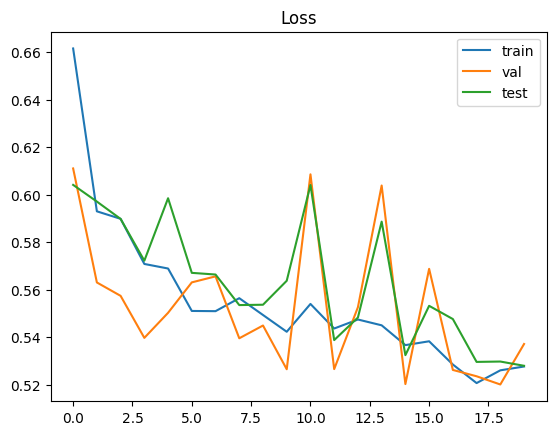

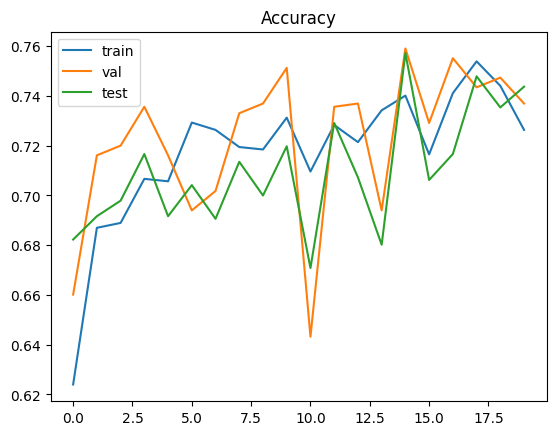

------------fold no---------4----------------------
Total samples in hospital A: 114
Total samples in hospital B: 103
Total samples in hospital C: 133
Total samples in hospital D: 139
Total samples in hospital E: 101
Total samples in hospital F: 427
Epoch 1: TrL=0.6439, TrA=0.6594, VL=0.6133, VA=0.6771, TeL=0.5835, TeA=0.7125, LR=0.00040,
Epoch 2: TrL=0.5870, TrA=0.7028, VL=0.6047, VA=0.6914, TeL=0.5747, TeA=0.7260, LR=0.00040,
Epoch 3: TrL=0.5631, TrA=0.7215, VL=0.5918, VA=0.7057, TeL=0.5625, TeA=0.7323, LR=0.00041,
Epoch 4: TrL=0.5486, TrA=0.7313, VL=0.6342, VA=0.6367, TeL=0.5939, TeA=0.6583, LR=0.00041,
Epoch 5: TrL=0.5710, TrA=0.7165, VL=0.6028, VA=0.6680, TeL=0.5593, TeA=0.7135, LR=0.00042,
Epoch 6: TrL=0.5461, TrA=0.7352, VL=0.6088, VA=0.6680, TeL=0.5761, TeA=0.6948, LR=0.00043,
Epoch 7: TrL=0.5352, TrA=0.7470, VL=0.6697, VA=0.6549, TeL=0.6421, TeA=0.6792, LR=0.00044,
Epoch 8: TrL=0.5409, TrA=0.7382, VL=0.6153, VA=0.6549, TeL=0.5808, TeA=0.6792, LR=0.00045,
Epoch 9: TrL=0.5416, T

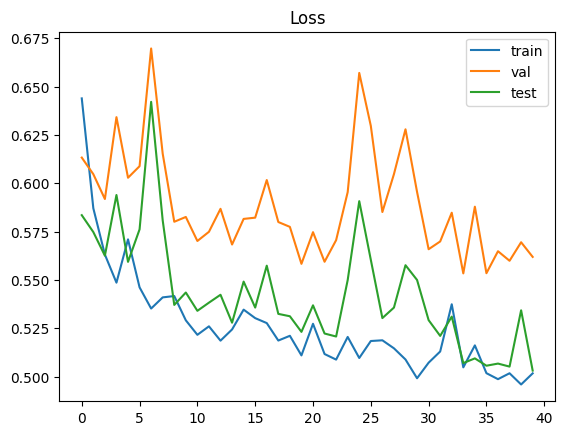

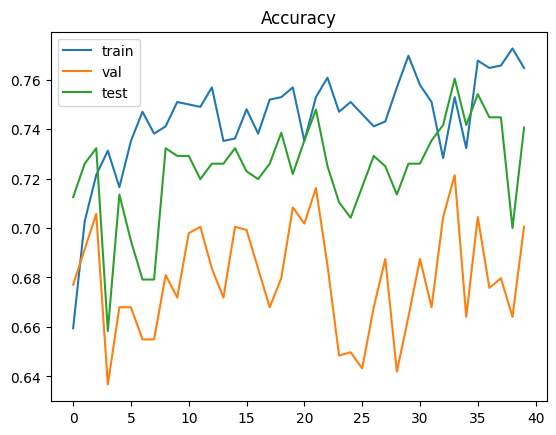

In [69]:
skf = StratifiedKFold(n_splits=5)
epochs=500
for fold,(train_idx, val_idx) in enumerate(skf.split(train_val, tv_labels)):
    writer = SummaryWriter("runs/STRATIFIED TEXT-ONLY", filename_suffix=f"_F{fold}_E{epochs}_")
    print('------------fold no---------{}----------------------'.format(fold))   
    train_df = df.iloc[train_idx]
    train_set = TextDataset(indices=train_df, image_dir=f"{data_path}DATASET", transform=my_transform)

    val_df = df.iloc[val_idx]
    val_set = TextDataset(indices=val_df, image_dir=f"{data_path}DATASET", transform=my_transform)
    
    print("Total samples in hospital A:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==1]))
    print("Total samples in hospital B:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==2]))
    print("Total samples in hospital C:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==3]))
    print("Total samples in hospital D:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==4]))
    print("Total samples in hospital E:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==5]))
    print("Total samples in hospital F:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==6]))
    
    train_loader = DataLoader(train_set, batch_size=8, num_workers=2, drop_last=True, shuffle=True, generator=generator)
    val_loader   = DataLoader(val_set,   batch_size=8, num_workers=2, drop_last=False, shuffle=False, generator=generator)
    
    # Define dictionary of loaders
    loaders = {"train": train_loader,
               "val": val_loader,
               "test": test_loader}

    # Define an optimizier
    import torch.optim as optim
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    # Define a loss 
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs=5, steps_per_epoch=350)
    
    
    #model, optimizer = ipex.optimize(model, optimizer=optimizer,dtype=torch.double)
    #model = model.float()
    # Train model
    train(model, loaders, optimizer, criterion, epochs=500, dev=dev)
    writer.flush()
    writer.close()
    model.apply(reset_weights)